# Sentiment Analysis Notebook
This notebook walks through dataset loading, preprocessing, EDA, model training, evaluation, and deployment steps.

## Dataset and evaluation overview
- Dataset: IMDB 50K movie reviews (Kaggle). The notebook expects `data/IMDB_Dataset.csv` with columns `review` and `sentiment`, which are normalized to `text` and `label`.
- Task: binary sentiment classification (positive vs negative).
- Recommended primary metric: weighted F1-score (balances precision and recall in case of minor class imbalance).
- For quick experiments the notebook samples data; to train final model run the full training cells.

In [ ]:
# Explicit data load cell (safe to run)
from pathlib import Path
project_root = Path('..').resolve()
from src.preprocessing import load_dataset
imdb_path = project_root / 'data' / 'IMDB_Dataset.csv'
sample_path = project_root / 'data' / 'sample_sentiment.csv'
if imdb_path.exists():
    df = load_dataset(str(imdb_path))
    if 'review' in df.columns and 'sentiment' in df.columns:
        df = df.rename(columns={'review': 'text', 'sentiment': 'label'})
else:
    df = load_dataset(str(sample_path))
print('Loaded dataset shape:', df.shape)


c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

LR eval on val: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
RF eval on val: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Best model test metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Best model test metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

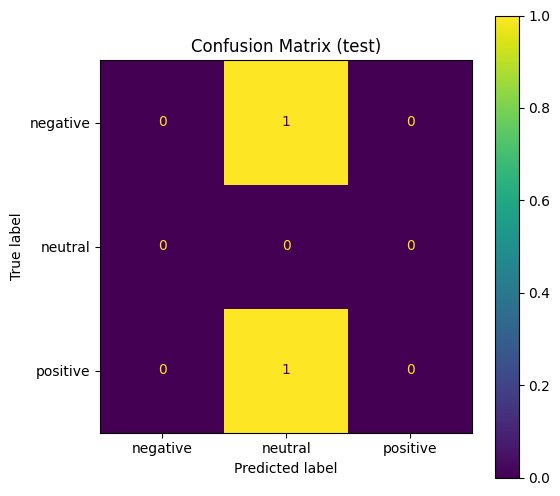

Saved pipeline to models/best_model.joblib


In [ ]:
# Modeling: TF-IDF + Logistic Regression / Random Forest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from src.models import build_tfidf_vectorizer, train_logistic_regression, train_random_forest, evaluate_model, save_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For speed, use a sample of training data if dataset is large (comment out for full training)
train_sample = train.sample(n=min(20000, len(train)), random_state=42)
val_sample = val.sample(n=min(5000, len(val)), random_state=42)
test_sample = test.sample(n=min(5000, len(test)), random_state=42)

vectorizer = build_tfidf_vectorizer(max_features=10000)

# Fit vectorizer on train_sample
X_train = vectorizer.fit_transform(train_sample['text'])
X_val = vectorizer.transform(val_sample['text'])
X_test = vectorizer.transform(test_sample['text'])

# Train Logistic Regression
lr = train_logistic_regression(X_train, train_sample['label'])
lr_val_metrics = evaluate_model(lr, X_val, val_sample['label'])
print('LR eval on val:', lr_val_metrics)

# Train Random Forest
rf = train_random_forest(X_train, train_sample['label'])
rf_val_metrics = evaluate_model(rf, X_val, val_sample['label'])
print('RF eval on val:', rf_val_metrics)

# Summary table of validation metrics
metrics_df = pd.DataFrame([{
    'model': 'LogisticRegression', 'accuracy': lr_val_metrics['accuracy'], 'precision': lr_val_metrics['precision'], 'recall': lr_val_metrics['recall'], 'f1': lr_val_metrics['f1']
}, {
    'model': 'RandomForest', 'accuracy': rf_val_metrics['accuracy'], 'precision': rf_val_metrics['precision'], 'recall': rf_val_metrics['recall'], 'f1': rf_val_metrics['f1']
}])
display(metrics_df)

# Choose best (by f1)
best_name = metrics_df.sort_values('f1', ascending=False).iloc[0]['model']
best = lr if best_name == 'LogisticRegression' else rf
print('Chosen best:', best_name)

# Evaluate on test_sample
test_metrics = evaluate_model(best, X_test, test_sample['label'])
print('Best model test metrics (sample):', test_metrics)

# Confusion matrix
cm = confusion_matrix(test_sample['label'], best.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_sample['label']))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title('Confusion Matrix (test sample)')
plt.show()

# ROC AUC (multiclass OVR) — compute only for classifiers that support predict_proba
if hasattr(best, 'predict_proba'):
    classes = np.unique(test_sample['label'])
    y_true_bin = label_binarize(test_sample['label'], classes=classes)
    y_score = best.predict_proba(X_test)
    try:
        auc = roc_auc_score(y_true_bin, y_score, average='weighted', multi_class='ovr')
        print('Weighted ROC AUC (ovr):', auc)
    except Exception as e:
        print('ROC AUC error:', e)

# Feature importance / coefficients (for LR show top positive/negative coefficients)
if best_name == 'LogisticRegression':
    coefs = best.coef_
    feature_names = vectorizer.get_feature_names_out()
    # For multiclass, show top features per class
    for i, cls in enumerate(best.classes_):
        top_idx = np.argsort(coefs[i])[-20:]
        top_features = feature_names[top_idx]
        print(f'Top positive features for class {cls}:', top_features[::-1][:10])

# Save the model: bundle vectorizer+model
import os
os.makedirs('models', exist_ok=True)
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vectorizer', vectorizer), ('clf', best)])
save_model(pipeline, 'models/best_model.joblib')
print('Saved pipeline to models/best_model.joblib')
